### Notebook to compare shelfstrat simulations with KPP and GLS $\kappa-\epsilon$ vertical mixing schemes 

In [1]:
#Packages - probably too many 
%matplotlib inline
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
from xhistogram.xarray import histogram
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as tick
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator

### Open model output 

In [2]:
def open_roms(path):
    ds1 = xroms.open_netcdf(path)
    ds1, grid1 = xroms.roms_dataset(ds1)
    return ds1, grid1

paths = ['shelf_dx_500_mpdata_uwind_osc_1_avg.nc', #KPP, backed up locally
         '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_mpdata_uwind_osc_1/shelf_dx_500_mpdata_uwind_osc_1_avg.nc', #Stored elsewhere on secure cluster
        ]
dsk, gridk = open_roms(paths[0])
dse, gride = open_roms(paths[1])

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/d2/home/dylan/.conda/envs/copano/lib/pyth

### Plot the surface salinity, vorticity and horizontal salinity gradient magnitude for comparison 

In [3]:
def surface_vorticity(ds, grid):
    '''
Calculates the surface vertical vorticity normalized by 
the Coriolis frequency. 
----
Inputs:
ds - Xarray Dataset
grid - XGCM grid object 
----
Outputs:
rvort_psi: Normalized vorticity on the psi points 

    '''
    u = ds.u.isel(s_rho=-1)
    v = ds.v.isel(s_rho=-1)

    dudy = grid.derivative(u, 'Y')
    dudy = xroms.to_rho(dudy, grid)
    dvdx = grid.derivative(v, 'X')
    dvdx = xroms.to_rho(dvdx, grid)

    rvort_rho = (dvdx-dudy)/ds.f
    
    return rvort_rho 

def surface_saltgradmag(ds, grid):
    '''
Calculates the surface horizontal salinity gradient magnitude normalized by 
the Coriolis frequency. 
----
Inputs:
ds - Xarray Dataset
grid - XGCM grid object 
----
Outputs:
sgradmag: horizontal salinity gradient magnitude on the psi points

    '''
    s = ds.salt.isel(s_rho=-1)

    dsdx = grid.derivative(s, 'X', boundary = 'extend')
    dsdx_psi = xroms.to_rho(dsdx, grid)
    dsdy = grid.derivative(s, 'Y', boundary = 'extend')
    dsdy_psi = xroms.to_rho(dsdy, grid)
    
    sgradmag = (dsdx_psi**2+dsdy_psi**2)**(1/2)
    
    return sgradmag

rvk = surface_vorticity(dsk, gridk)
rve = surface_vorticity(dse, gride)

sgradk = surface_saltgradmag(dsk, gridk)
sgrade = surface_saltgradmag(dse, gride)

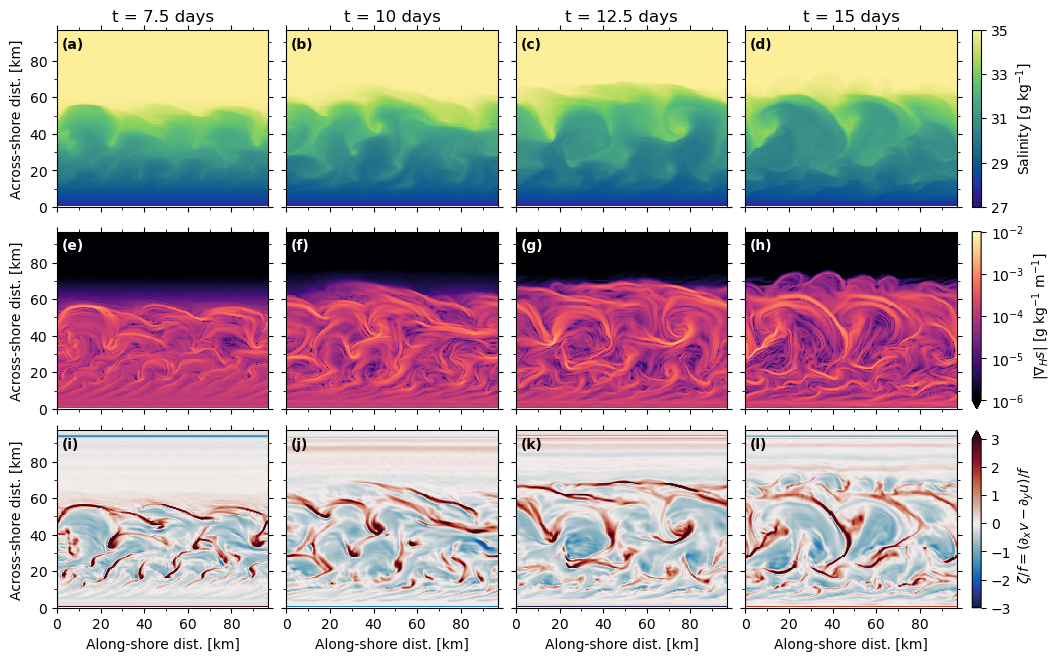

In [7]:
fig, ax = plt.subplots(3,4, figsize = ((7/2)*3,6.5), constrained_layout = True)

#salt
xrho = (dse.x_rho/1000)[1:].values
yrho = (dse.y_rho/1000)[1:].values

mappable1 = ax[0,0].pcolormesh(xrho, yrho, dse.salt[156,-1, 1:].values, cmap = cmo.haline, vmin = 27, vmax = 35)
mappable2 = ax[0,1].pcolormesh(xrho, yrho, dse.salt[216,-1, 1:].values, cmap = cmo.haline, vmin = 27, vmax = 35)
mappable3 = ax[0,2].pcolormesh(xrho, yrho, dse.salt[276,-1, 1:].values, cmap = cmo.haline, vmin = 27, vmax = 35)
mappable4 = ax[0,3].pcolormesh(xrho, yrho, dse.salt[336,-1, 1:].values, cmap = cmo.haline, vmin = 27, vmax = 35)

cbar = fig.colorbar(mappable4, ax = ax[0,3], label = '', ticks = [27, 29, 31, 33, 35],)
cbar.ax.set_ylabel(r'Salinity [g kg$^{-1}$]')

sfill = sgrade[156,1:].where(sgrade[156,1:]>1e-6)
sfill0 = sfill.fillna(value=1e-6)
sfill1 = sgrade[216,1:].where(sgrade[216,1:]>1e-6)
sfill01 = sfill1.fillna(value=1e-6)
sfill2 = sgrade[276,1:].where(sgrade[276,1:]>1e-6)
sfill02 = sfill2.fillna(value=1e-6)
sfill3 = sgrade[336,1:].where(sgrade[336,1:]>1e-6)
sfill03 = sfill3.fillna(value=1e-6)

mappable5 = ax[1,0].pcolormesh(xrho, yrho, np.log10(sfill0), cmap = plt.get_cmap('magma'), vmin = -6, vmax = -2)
mappable6 = ax[1,1].pcolormesh(xrho, yrho, np.log10(sfill01), cmap = plt.get_cmap('magma'), vmin = -6, vmax = -2)
mappable7 = ax[1,2].pcolormesh(xrho, yrho, np.log10(sfill02), cmap = plt.get_cmap('magma'), vmin = -6, vmax = -2)
mappable8 = ax[1,3].pcolormesh(xrho, yrho, np.log10(sfill03), cmap = plt.get_cmap('magma'), vmin = -6, vmax = -2)
cbar = fig.colorbar(mappable8, ax = ax[1,3], label = '', extend = 'min', format=tick.FormatStrFormatter('$10^{%d}$'))
cbar.ax.set_ylabel(r'$|\nabla_H s|$ [g kg$^{-1}$ m$^{-1}$]')

mappable9 = ax[2,0].pcolormesh(xrho, yrho, rve[156,1:], cmap = plt.get_cmap('cmo.balance'), vmin = -3, vmax = 3)
mappable10 = ax[2,1].pcolormesh(xrho, yrho, rve[216,1:], cmap = plt.get_cmap('cmo.balance'), vmin = -3, vmax = 3)
mappable11 = ax[2,2].pcolormesh(xrho, yrho, rve[276,1:], cmap = plt.get_cmap('cmo.balance'), vmin = -3, vmax = 3)
mappable12 = ax[2,3].pcolormesh(xrho, yrho, rve[336,1:], cmap = plt.get_cmap('cmo.balance'), vmin = -3, vmax = 3)
cbar = fig.colorbar(mappable12, ax = ax[2,3], label = '', extend = 'max', ticks = [-3,-2,-1,0,1,2,3])
cbar.ax.set_ylabel(r'$\zeta/f=(\partial_x v - \partial_y u)/f$')

for i in range(3):
    for j in range(4):
        ax[i,j].set(xlim=[0,97], ylim=[0,97])
        ax[i,0].set_ylabel('Across-shore dist. [km]')
        ax[2,j].set_xlabel('Along-shore dist. [km]')
        ax[i,1].set_yticklabels([])
        ax[i,2].set_yticklabels([])
        ax[i,3].set_yticklabels([])
        ax[i,j].set_xticks(np.arange(0,100,20))
        minor_locator = AutoMinorLocator(2)
        ax[i,j].xaxis.set_minor_locator(minor_locator)
        ax[i,j].yaxis.set_minor_locator(minor_locator)
        ax[i,j].tick_params(which = 'both',bottom=True, top=True, left=True, right=True)
        ax[i,j].tick_params(which = 'both',labelbottom=True, labeltop=False, labelleft=True, labelright=False)

for i in range(2):
    for j in range(4):
        ax[i,j].set_xticklabels([])

ax[0,0].set_title(r't = 7.5 days')
ax[0,1].set_title(r't = 10 days')
ax[0,2].set_title(r't = 12.5 days')
ax[0,3].set_title(r't = 15 days')

ax[0,0].text(2,87, '(a)', fontweight = 'semibold')
ax[0,1].text(2,87, '(b)', fontweight = 'semibold')
ax[0,2].text(2,87, '(c)', fontweight = 'semibold')
ax[0,3].text(2,87, '(d)', fontweight = 'semibold')
ax[1,0].text(2,87, '(e)', fontweight = 'semibold', color = 'white')
ax[1,1].text(2,87, '(f)', fontweight = 'semibold', color = 'white')
ax[1,2].text(2,87, '(g)', fontweight = 'semibold', color = 'white')
ax[1,3].text(2,87, '(h)', fontweight = 'semibold', color = 'white')
ax[2,0].text(2,87, '(i)', fontweight = 'semibold')
ax[2,1].text(2,87, '(j)', fontweight = 'semibold')
ax[2,2].text(2,87, '(k)', fontweight = 'semibold')
ax[2,3].text(2,87, '(l)', fontweight = 'semibold')
plt.savefig('GLS_surface_0p1_dx_500.jpg', dpi = 600, bbox_inches='tight')

# Repeat for KPP

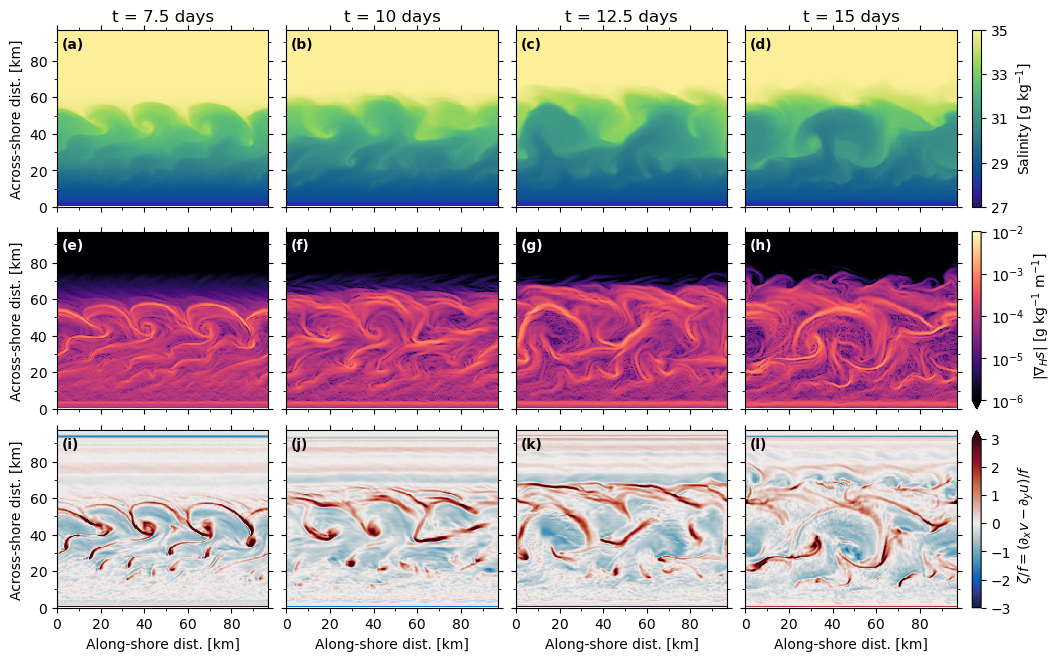

In [8]:
fig, ax = plt.subplots(3,4, figsize = ((7/2)*3,6.5), constrained_layout = True)

#salt
xrho = (dsk.x_rho/1000)[1:].values
yrho = (dsk.y_rho/1000)[1:].values

mappable1 = ax[0,0].pcolormesh(xrho, yrho, dsk.salt[156,-1, 1:].values, cmap = cmo.haline, vmin = 27, vmax = 35)
mappable2 = ax[0,1].pcolormesh(xrho, yrho, dsk.salt[216,-1, 1:].values, cmap = cmo.haline, vmin = 27, vmax = 35)
mappable3 = ax[0,2].pcolormesh(xrho, yrho, dsk.salt[276,-1, 1:].values, cmap = cmo.haline, vmin = 27, vmax = 35)
mappable4 = ax[0,3].pcolormesh(xrho, yrho, dsk.salt[336,-1, 1:].values, cmap = cmo.haline, vmin = 27, vmax = 35)

cbar = fig.colorbar(mappable4, ax = ax[0,3], label = '', ticks = [27, 29, 31, 33, 35],)
cbar.ax.set_ylabel(r'Salinity [g kg$^{-1}$]')

sfill = sgradk[156,1:].where(sgradk[156,1:]>1e-6)
sfill0 = sfill.fillna(value=1e-6)
sfill1 = sgradk[216,1:].where(sgradk[216,1:]>1e-6)
sfill01 = sfill1.fillna(value=1e-6)
sfill2 = sgradk[276,1:].where(sgradk[276,1:]>1e-6)
sfill02 = sfill2.fillna(value=1e-6)
sfill3 = sgradk[336,1:].where(sgradk[336,1:]>1e-6)
sfill03 = sfill3.fillna(value=1e-6)

mappable5 = ax[1,0].pcolormesh(xrho, yrho, np.log10(sfill0), cmap = plt.get_cmap('magma'), vmin = -6, vmax = -2)
mappable6 = ax[1,1].pcolormesh(xrho, yrho, np.log10(sfill01), cmap = plt.get_cmap('magma'), vmin = -6, vmax = -2)
mappable7 = ax[1,2].pcolormesh(xrho, yrho, np.log10(sfill02), cmap = plt.get_cmap('magma'), vmin = -6, vmax = -2)
mappable8 = ax[1,3].pcolormesh(xrho, yrho, np.log10(sfill03), cmap = plt.get_cmap('magma'), vmin = -6, vmax = -2)
cbar = fig.colorbar(mappable8, ax = ax[1,3], label = '', extend = 'min', format=tick.FormatStrFormatter('$10^{%d}$'))
cbar.ax.set_ylabel(r'$|\nabla_H s|$ [g kg$^{-1}$ m$^{-1}$]')

mappable9 = ax[2,0].pcolormesh(xrho, yrho, rvk[156,1:], cmap = plt.get_cmap('cmo.balance'), vmin = -3, vmax = 3)
mappable10 = ax[2,1].pcolormesh(xrho, yrho, rvk[216,1:], cmap = plt.get_cmap('cmo.balance'), vmin = -3, vmax = 3)
mappable11 = ax[2,2].pcolormesh(xrho, yrho, rvk[276,1:], cmap = plt.get_cmap('cmo.balance'), vmin = -3, vmax = 3)
mappable12 = ax[2,3].pcolormesh(xrho, yrho, rvk[336,1:], cmap = plt.get_cmap('cmo.balance'), vmin = -3, vmax = 3)
cbar = fig.colorbar(mappable12, ax = ax[2,3], label = '', extend = 'max', ticks = [-3,-2,-1,0,1,2,3])
cbar.ax.set_ylabel(r'$\zeta/f=(\partial_x v - \partial_y u)/f$')

for i in range(3):
    for j in range(4):
        ax[i,j].set(xlim=[0,97], ylim=[0,97])
        ax[i,0].set_ylabel('Across-shore dist. [km]')
        ax[2,j].set_xlabel('Along-shore dist. [km]')
        ax[i,1].set_yticklabels([])
        ax[i,2].set_yticklabels([])
        ax[i,3].set_yticklabels([])
        ax[i,j].set_xticks(np.arange(0,100,20))
        minor_locator = AutoMinorLocator(2)
        ax[i,j].xaxis.set_minor_locator(minor_locator)
        ax[i,j].yaxis.set_minor_locator(minor_locator)
        ax[i,j].tick_params(which = 'both',bottom=True, top=True, left=True, right=True)
        ax[i,j].tick_params(which = 'both',labelbottom=True, labeltop=False, labelleft=True, labelright=False)

for i in range(2):
    for j in range(4):
        ax[i,j].set_xticklabels([])

ax[0,0].set_title(r't = 7.5 days')
ax[0,1].set_title(r't = 10 days')
ax[0,2].set_title(r't = 12.5 days')
ax[0,3].set_title(r't = 15 days')

ax[0,0].text(2,87, '(a)', fontweight = 'semibold')
ax[0,1].text(2,87, '(b)', fontweight = 'semibold')
ax[0,2].text(2,87, '(c)', fontweight = 'semibold')
ax[0,3].text(2,87, '(d)', fontweight = 'semibold')
ax[1,0].text(2,87, '(e)', fontweight = 'semibold', color = 'white')
ax[1,1].text(2,87, '(f)', fontweight = 'semibold', color = 'white')
ax[1,2].text(2,87, '(g)', fontweight = 'semibold', color = 'white')
ax[1,3].text(2,87, '(h)', fontweight = 'semibold', color = 'white')
ax[2,0].text(2,87, '(i)', fontweight = 'semibold')
ax[2,1].text(2,87, '(j)', fontweight = 'semibold')
ax[2,2].text(2,87, '(k)', fontweight = 'semibold')
ax[2,3].text(2,87, '(l)', fontweight = 'semibold')
# plt.savefig('GLS_surface_0p1_dx_500.jpg', dpi = 600, bbox_inches='tight')
plt.savefig('KPP_surface_0p1_dx_500.jpg', dpi = 600, bbox_inches='tight')